In [33]:
#!pip install segmentation_models_pytorch

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import  os
import segmentation_models_pytorch as smp

In [ ]:
#!unzip "/content/drive/MyDrive/PyTorch/archive.zip" -d "/content/drive/MyDrive/PyTorch"

In [2]:
masks = []
for root, dir, files in os.walk('/Users/Viktoryia/Documents/gb/pytorch/Lecture05/set-lipstick-original/mask'):
  for name in files:
    filepath = os.path.join(root, name)
    masks.append(filepath)
len(masks)

28540

In [3]:
images = []
for root, dir, files in os.walk('/Users/Viktoryia/Documents/gb/pytorch/Lecture05/set-lipstick-original/720p'):
  for name in files:
    filepath = os.path.join(root, name)
    images.append(filepath)
len(images)

28594

In [4]:
# длинна отличается на 54 картинки, сортируем их по номеру и удаляем лишнее
images = sorted(images, key=lambda x: int(x.split('image')[1].split('.')[0]))
masks = sorted(masks, key=lambda x: int(x.split('mask')[-1].split('.')[0]))
len(images), len(masks)

(28594, 28540)

In [5]:
for ind, el in enumerate(images):
  if int(el.split('image')[1].split('.')[0]) != int(masks[ind].split('mask')[-1].split('.')[0]):
    images.remove(images[ind])

In [6]:
# профит)
len(images), len(masks)

(28540, 28540)

In [7]:
final_df = pd.DataFrame({'Image':images, "Mask":masks})

In [8]:
final_df.to_csv('df.csv', index=False)
df = pd.read_csv('df.csv')

In [9]:
df.head()

,Image,Mask
0,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...
1,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...
2,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...
3,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...
4,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...,/Users/Viktoryia/Documents/gb/pytorch/Lecture0...


In [10]:
# Посмотрим с чем предстоит работать. Пришлось повозиться, но вроде вышло интерактивно
def show_images(df, start_index, num_images, figsize):
      ''' start_index: от какого изображения начинаем
      num_images: количество отображаемых строк картинка-маска
      figsize: размер фигуры кортежем из 2х чисел'''
  if start_index + num_images > len(df):
    print(f'index {start_index} is not avalible, check last {num_images} images')
    start_index = len(df) - num_images 
    
  for i in range(num_images):
    fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=figsize)  
    ax1.imshow(read_image((df['Image'].iloc[start_index + i])).permute(1, 2, 0))
    ax1.set_title(start_index + i)
    ax2.imshow(read_image((df['Mask'].iloc[start_index + i])).permute(1, 2, 0))
    ax2.set_title(start_index + i)

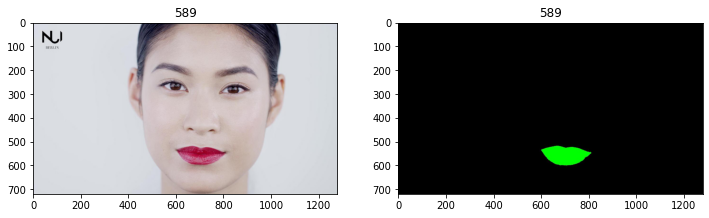

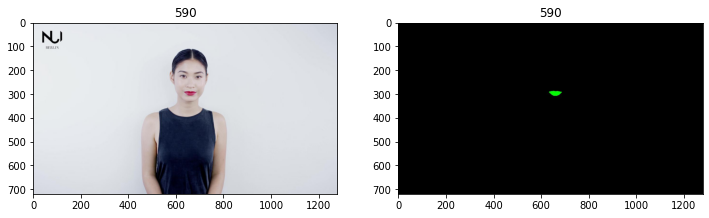

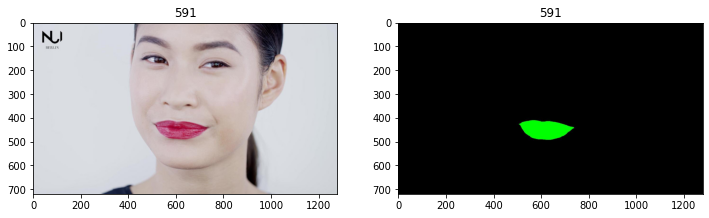

In [11]:
show_images(final_df, 589, 3, (12, 8))

In [34]:
img = Image.open(final_df['Image'].iloc[0])
img = img.resize((256, 256))
img = np.asarray(img).astype('float64')
img = torch.as_tensor(img) / 255
#img = img.permute(2, 0, 1)

In [35]:
print(img.shape)

torch.Size([256, 256, 3])


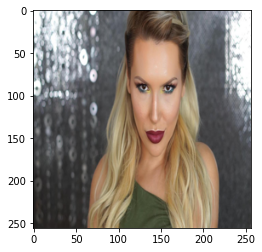

In [37]:
plt.imshow(img)

In [42]:
# Это тот вид, который мне удалось подать в обучение, не знаю,
# насколько это корректно, но больше ничего не вышло,
# другие варианты (как в функции выше) модель не берет

mk = Image.open(final_df['Mask'].iloc[2])
mk = mk.resize((256, 256))
mk = np.asarray(mk).astype('float64')
mk = torch.as_tensor(mk) / 255
mk = mk[:, :, 0].unsqueeze(2)
#mk = mk.permute(2, 0, 1)
#mk = mk.unsqueeze(0)
mk.shape

torch.Size([256, 256, 1])

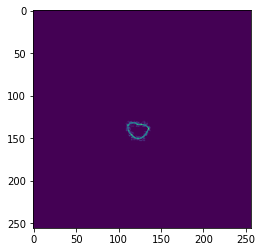

In [43]:
plt.imshow(mk)

In [12]:
class LipsDataset:
    
    def __init__(self, i, m):
        self.images = i
        self.masks = m 

    def __len__(self):
        return len(self.images)

    @classmethod
    def preprocess_image(cls, image):
        img = Image.open(image)
        img = img.resize((256, 256))
        img = np.asarray(img).astype('float64')
        img = torch.as_tensor(img) / 255
        img = img.permute(2, 0, 1).unsqueeze(0)
        return img  
  

    @classmethod
    def preprocess_mask(cls, mask):
        mk = Image.open(mask)
        mk = mk.resize((256, 256))
        mk = np.asarray(mk).astype('float64')
        mk = torch.as_tensor(mk) / 255 
        if len(mk.shape) < 3:    Ох как я намучалась с обработкой масок, все время вылетала с ошибками несовпадения
            mk = mk.unsqueeze(2) размерностей всех мастей. Из самого неприятного - на четверти обучения кусок
        mk = mk[:,:, 0]          mk = mk[:,:, 0] выдавал ошибку слишком короткого массива (из 2 элементов вместо 3),
        mk = mk.unsqueeze(2)     причем квадратно-гнездовым методом в разных местах.
        mk = mk.permute(2, 0, 1) Добавила проверку длинны, но до этого простого решения я дошла не сразу:
        mk = mk.unsqueeze(0)     танцев с бубном вокруг маски било очень много. Я вообще не понимаю эти размерности
        return mk                и как ими манипулировать - действовала методом научного тыка.
                                 Хотела-бы знать: 1) Правильно-ли я предобработала маску?

    def __getitem__(self, idx):
        image = self.preprocess_image(self.images[idx])
        mask = self.preprocess_mask(self.masks[idx])
        return image, mask

In [13]:
X_train,X_test, y_train, y_test = train_test_split(final_df['Image'].tolist(), final_df['Mask'].tolist(),
                                                   random_state=42, test_size=0.25)

In [14]:
train = LipsDataset(X_train, y_train)
test = LipsDataset(X_test, y_test)

In [15]:
train_loader = torch.utils.data.DataLoader(train,batch_size=100,shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=100,shuffle=False, drop_last=True)

In [239]:
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet',classes=1,activation='sigmoid')

In [240]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [241]:
len(train_loader)

214

In [242]:
import time
from torch.autograd import Variable
epoch_losses = []
model.double()
for epoch in range(3):
    time1 = time.time()
    epoch_loss = []
    for batch_idx, data in enumerate(train_loader):        
        inputs, labels = data[0], data[1] 
        optimizer.zero_grad()
     
        outputs = model(inputs[0, :, :, :, :].double())   # вот тут я вообще не понимаю, вылетала с ошибкой 
                                                          # размер [100, 1, 1, 256, 256], должн быть
                                                          # [1, 1, 256, 256], пришлось вот так коряво обрезать
                                                          # 2) но разве из поданного батча не извлекается размерность
                                                          # элемента?
        loss = criterion(outputs, labels[0, :, :, :, :].double())
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx%100==0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

batch index : 0 | loss : 0.7347601267907011
batch index : 100 | loss : 0.02156334626995394
batch index : 200 | loss : 0.007194905145730003
Epoch 1, loss:  0.06263677834498775
Spend time for 1 epoch: 1779.9817831516266 sec
batch index : 0 | loss : 0.006573127894474073
batch index : 100 | loss : 0.0037138434402601145
batch index : 200 | loss : 0.0024564438311333483
Epoch 2, loss:  0.004042955769333454
Spend time for 1 epoch: 1773.6601541042328 sec
batch index : 0 | loss : 0.002398078529888123
batch index : 100 | loss : 0.0026658214367995727
batch index : 200 | loss : 0.0020250827467740177
Epoch 3, loss:  0.0021810691049226377
Spend time for 1 epoch: 1775.793743133545 sec


In [243]:
torch.save(model, '/Users/Viktoryia/Documents/gb/pytorch/Lecture05/model_2')

In [16]:
saved_2 = torch.load('model_2')

In [17]:
data_iter_2 = iter(train_loader)
image_2, label_2 = data_iter_2.next()

In [18]:
# при попытке предсказать целый батч или даже 20 картинок все тут-же отваливаетс
# по хорошему надо - бы добавить IoU, но в обучение я забыла, а в тест уже не судьба
out_2 = []
for ind, i in enumerate(image_2):
    if ind > 15:
        break
    i = saved_2(i)
    out_2.append(i)

In [26]:
# доработала функцию на результат, для трех эпох сносно, на больше у ноута силенок не хватило,
# а колаб сейчас расстраивает
def show_final_images(image, label, prediction, start_index, num_images, figsize):
    ''' start_index: от какого изображения начинаем
      num_images: количество отображаемых строк (картинка-маска):
      figsize: размер фигуры кортежем из 2х чисел'''
    if start_index + num_images > len(image):
        print(f'index {start_index} is not avalible, check last {num_images} images')
        start_index = len(image) - num_images 
    
    for i in range(num_images):
        fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, figsize=figsize)  
        ax1.imshow(image[start_index + i].squeeze(0).permute(1, 2, 0))
        ax1.set_title("Image")
        ax2.imshow(label[start_index + i].squeeze(0).permute(1, 2, 0))
        ax2.set_title("True_mask")
        ax3.imshow(np.squeeze(prediction[start_index + i].permute(1, 2, 3, 0).detach().numpy(), 0))
        ax3.set_title('Predicted_mask')
      

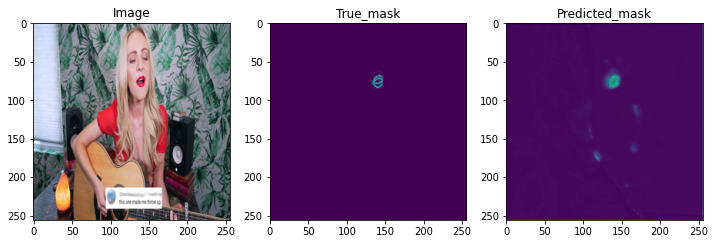

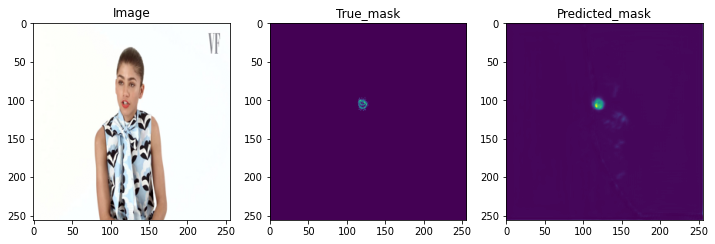

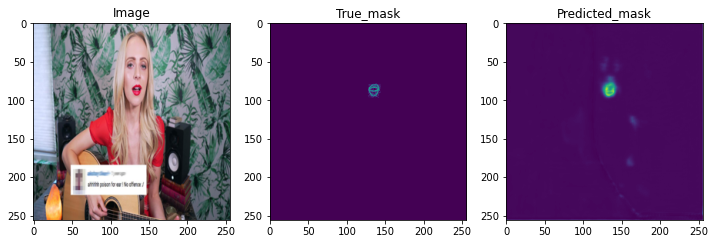

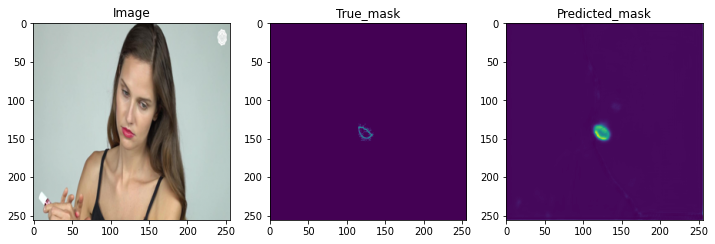

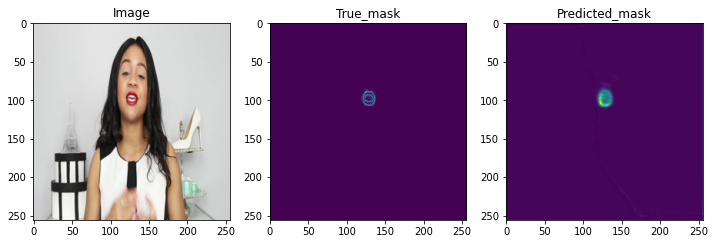

In [32]:
# Обучающие данные
show_final_images(image_2, label_2, out_2, 7, 5, (12, 8))

In [44]:
test = iter(test_loader)
test_img, test_mk = test.next()

In [45]:
test_out = []
for ind, i in enumerate(test_img):
    if ind > 15:
        break
    i = saved_2(i)
    test_out.append(i)

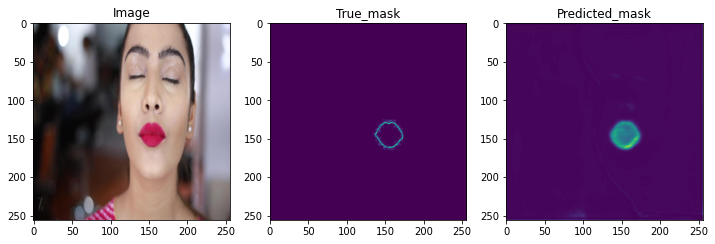

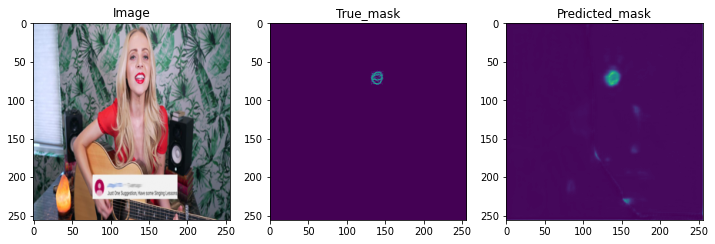

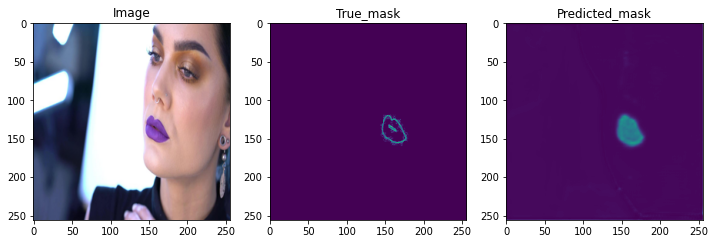

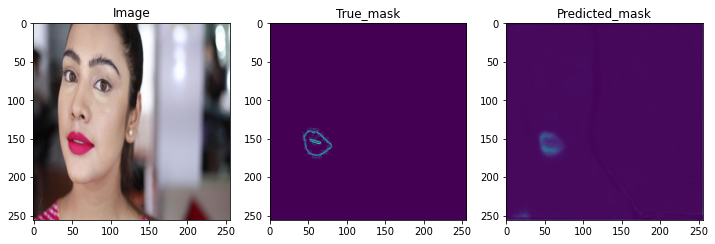

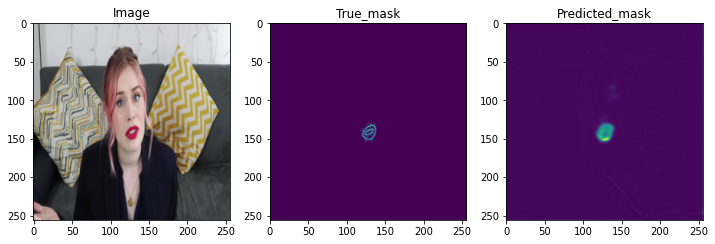

In [52]:
# Ну и тестовые
# Пожалуйста, прокомментируйте работу в целом и предобработку данных в частности.
# 3) Где почитать про размерности и как с ними работать?
show_final_images(test_img, test_mk, test_out, 6, 5, (12, 8))